## Contents:
* [Loading packages](#Loading_packages)
* [Reading cell2location model output and defining useful functions](#read)

* [FigS6B](#FigS6B)
* [Fig2C](#Fig2C)
* [FigS6C](#FigS6C)
* [FigS6D](#FigS6D)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
#sys.path.insert(1, '/sanger_projects/cell2location/')
#sys.path.insert(1, '/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


### Reading cell2location model output and defining useful functions <a class="anchor" id="read"></a> 

In [2]:
# read a previously trained LocationModel
#results_folder = '/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'

sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [3]:
# annotate region clusters
region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)
region_annot.index.name = 'region_cluster'
region_annot = region_annot.reindex(index = list(adata_vis.obs['region_cluster']))
region_annot.index = adata_vis.obs_names

adata_vis.obs[region_annot.columns] = region_annot

In [4]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y
    

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'region_final' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


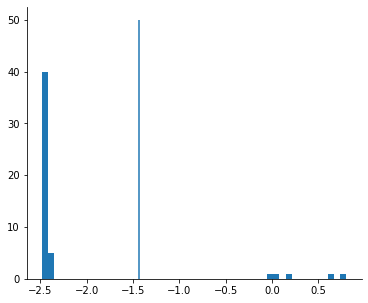

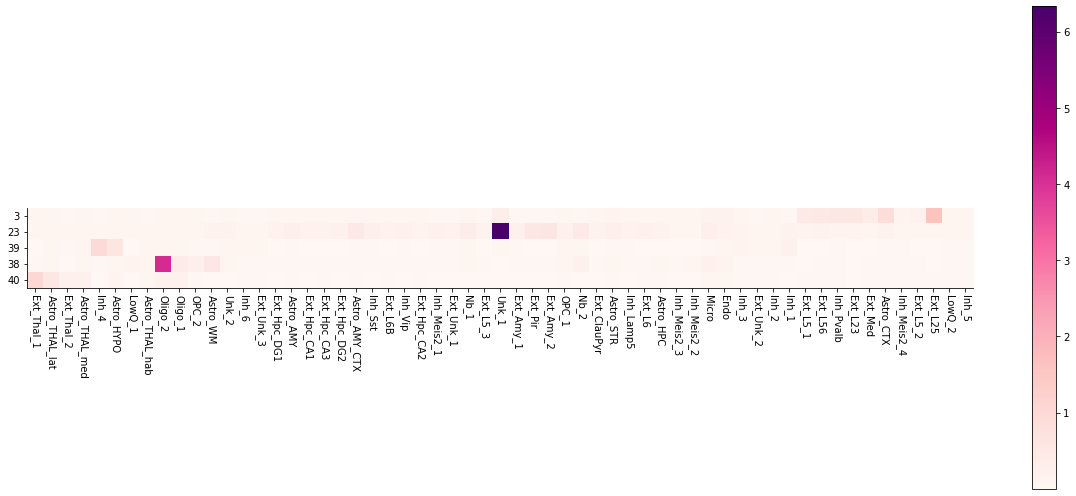

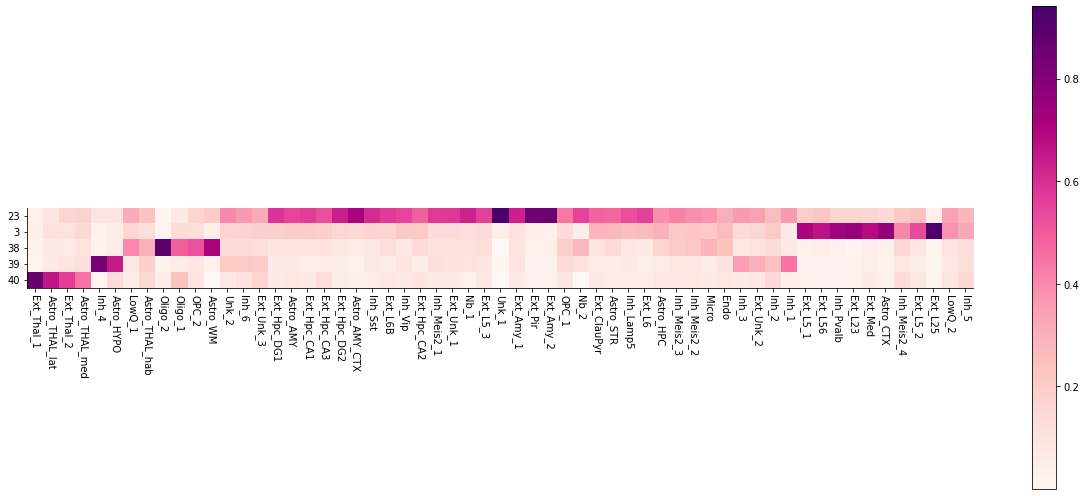

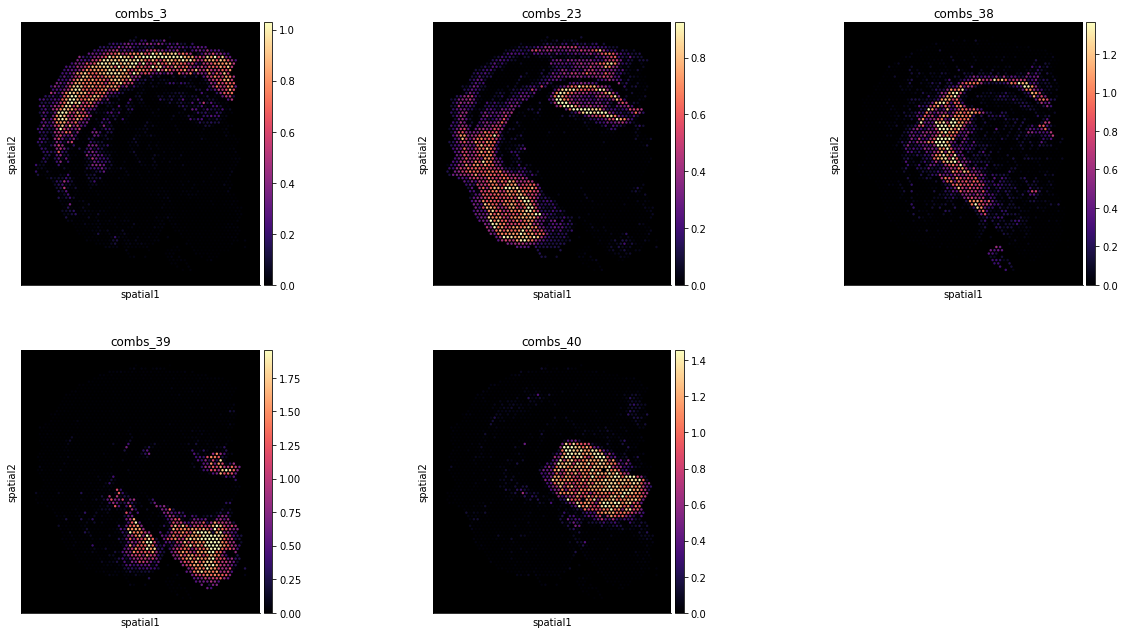

In [5]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['comb2fact'],
                            columns=adata_vis.uns['mod']['fact_names'])

rcParams["figure.figsize"] = [6, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=50);
thresh = 0.037
plt.vlines(np.log10(thresh), 0, 50);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figure_size=(17, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figure_size=(17, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['combs_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['combs_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors

slide = select_slide(adata_vis, 'ST8059048')
crop_x, crop_y = get_crop_coord(slide)

s = 'spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(slide, cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

### Now we compare the estimated number of cells to numbers observed by segmentation of nuclei in histology images.

In [7]:
# read in positions of segmented nuclei for each sample
adata_vis.obs['image_name_i'] = [i[41:-4] for i in adata_vis.obs['image_name']]

segm_res = {}
for i in adata_vis.obs['image_name_i'].unique():
    
    sample_name = adata_vis.obs.loc[adata_vis.obs['image_name_i'] == i,
                                    'sample'].unique()[0]
    
    res = pd.read_csv(results_folder + 'segmentation/' + i + '.csv')
    res['image_name_i'] = i
    res['sample_name'] = sample_name
    segm_res[i] = res
    
    
    
    path_segm = results_folder + 'segmentation/color/' + i + '_color.jpg'
    from cv2 import imread
    full_img_segm = imread(path_segm, -1)
    
    spatial_names = np.array(list(adata_vis.uns['spatial'].keys()))
    spatial_name = spatial_names[[sample_name in i for i in spatial_names]][0]
    adata_vis.uns['spatial'][spatial_name]['scalefactors']['tissue_lowres_scalef'] = 1
    adata_vis.uns['spatial'][spatial_name]['images']['lowres'] = full_img_segm

segm_res = pd.concat(list(segm_res.values()), axis=0)

# filter segmented nuclei by size
segm_res = segm_res.loc[segm_res['size'] < 10**3.3,:]

#plt.hist(np.log10(segm_res['size']), bins=100);
#plt.vlines(3.3, 0, 10000);

def map_nuclei2spots(nuclei_df, adata, sample_ind, radius=None):
    
    from sklearn.neighbors import KDTree
    
    if radius is None:
        
        spatial_names = np.array(list(adata.uns['spatial'].keys()))
        spatial_name = spatial_names[[sample in i for i in spatial_names]][0]
        radius = adata.uns['spatial'][spatial_name]['scalefactors']['spot_diameter_fullres'] / 2
        
    # count nuclei within spots
    tree = KDTree(nuclei_df[['x', 'y']].values)

    adata.obs.loc[sample_ind, 'nuclei_count'] = tree.query_radius(adata.obsm['spatial'][sample_ind,:],
                                                                  radius, count_only=True)
    # measure averages size and std
    spotind = tree.query_radius(adata.obsm['spatial'][sample_ind,:], radius, count_only=False)
    adata.obs.loc[sample_ind, 'nuclei_size_sum'] = [nuclei_df['size'].values[spot].sum() for spot in spotind]
    adata.obs.loc[sample_ind, 'nuclei_size_mean'] = [nuclei_df['size'].values[spot].mean() for spot in spotind]
    adata.obs.loc[sample_ind, 'nuclei_size_std'] = [nuclei_df['size'].values[spot].std() for spot in spotind]
    
    
for s in adata_vis.obs['sample'].unique():
    
    spatial_names = np.array(list(adata_vis.uns['spatial'].keys()))
    spatial_name = spatial_names[[s in i for i in spatial_names]][0]
    
    map_nuclei2spots(segm_res.loc[segm_res['sample_name'].isin([str(s)]), :], 
                     adata_vis, adata_vis.obs['sample'].isin([s]), 
                     radius=adata_vis.uns['spatial'][spatial_name]['scalefactors']['spot_diameter_fullres'] / 2 * 1.1)

# compute total number of nuclei per section
segm_res['sample_name'].value_counts()

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.
/n

ST8059049    51300
ST8059048    48357
ST8059050    47831
ST8059052    46507
ST8059051    43680
Name: sample_name, dtype: int64

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.


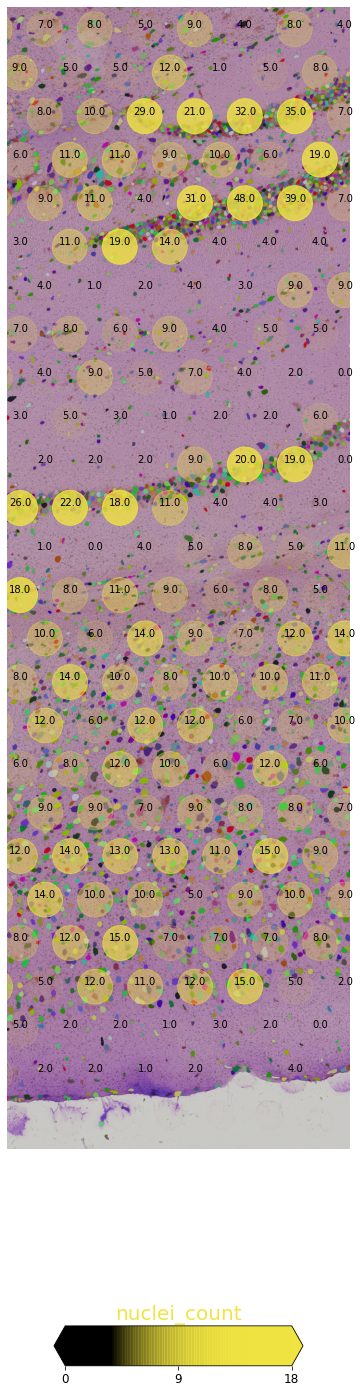

In [8]:
crop_x = [10000, 11500]
crop_y = [7500, 2500]

# select up to 6 clusters 
sel_clust = ['nuclei_count']
sel_clust_col = sel_clust
slide = select_slide(adata_vis, 'ST8059048')

from cell2location.plt.mapping_video import plot_spatial

rcParams["figure.figsize"] = [25, 25]
#rcParams["axes.facecolor"] = "black"
text = pd.DataFrame(slide.obsm['spatial'])
text['count'] = np.round(slide.obs['nuclei_count'].values)
text = text.loc[np.array(text[0] > crop_x[0]) & np.array(text[0] < crop_x[1]), :]
text = text.loc[np.array(text[1] < crop_y[0]) & np.array(text[1] > crop_y[1]), :]

fig = plot_spatial((slide.obs[sel_clust_col]), labels=sel_clust_col,  
              coords=slide.obsm['spatial'], 
              text=text, text_box_alpha=0,
              show_img=True, img_alpha=0.8,
              img=list(slide.uns['spatial'].values())[0]['images']['lowres'],
              circle_diameter=35, alpha_scaling=0.8,
              crop_x=crop_x, crop_y=crop_y)

### Fig S6B <a class="anchor" id="FigS6B"></a> 

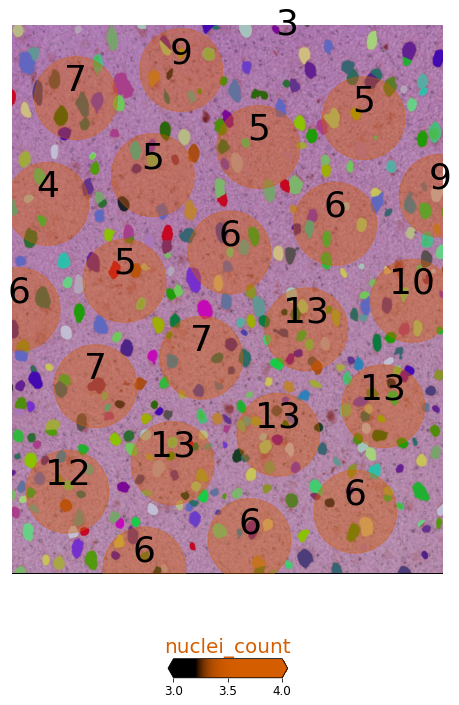

In [9]:
from cell2location.plt.RotateCrop import RotateCrop
from cell2location.plt.RotateCrop import find_rectangle_corners

dots = slide.obsm['spatial'] 

#scaling factor between images# picture width
width = 100
# picture left side segment
bottom_left = np.array([[430, 610], [520, 700]])

points = find_rectangle_corners(bottom_left, width)
points = points / list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']

rc = RotateCrop(list(slide.uns['spatial'].values())[0]['images']['lowres'],
                points, rotate90=1, flip_axes=False)
cropped = rc.crop_rotate()
dots_, mask = rc.rotate_points(dots, return_mask=True)

text = pd.DataFrame(slide.obsm['spatial'])
text['count'] = np.round(slide.obs['nuclei_count'].values, 0).astype(int)
text = text.loc[mask, :]
text[[0, 1]] = dots_

rcParams["font.size"] = 36
rcParams["figure.figsize"] = [12, 12]
plot_spatial((slide.obs.loc[mask,:][['nuclei_count']]), labels=sel_clust_col,
              text=text, text_box_alpha=0, #fontsize=25,
              coords=dots_, 
              show_img=True, img_alpha=0.85,
              img=cropped,
              circle_diameter=83, alpha_scaling=0.4,
              reorder_cmap=[1], max_col=[4],
              crop_y=[0, cropped.shape[0]], crop_x=[0, cropped.shape[1]],
              #overwrite_color=np.array([[0.5, 0.5, 0.9, 0.9]])
            );


### Fig 2C <a class="anchor" id="Fig2C"></a> 

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.


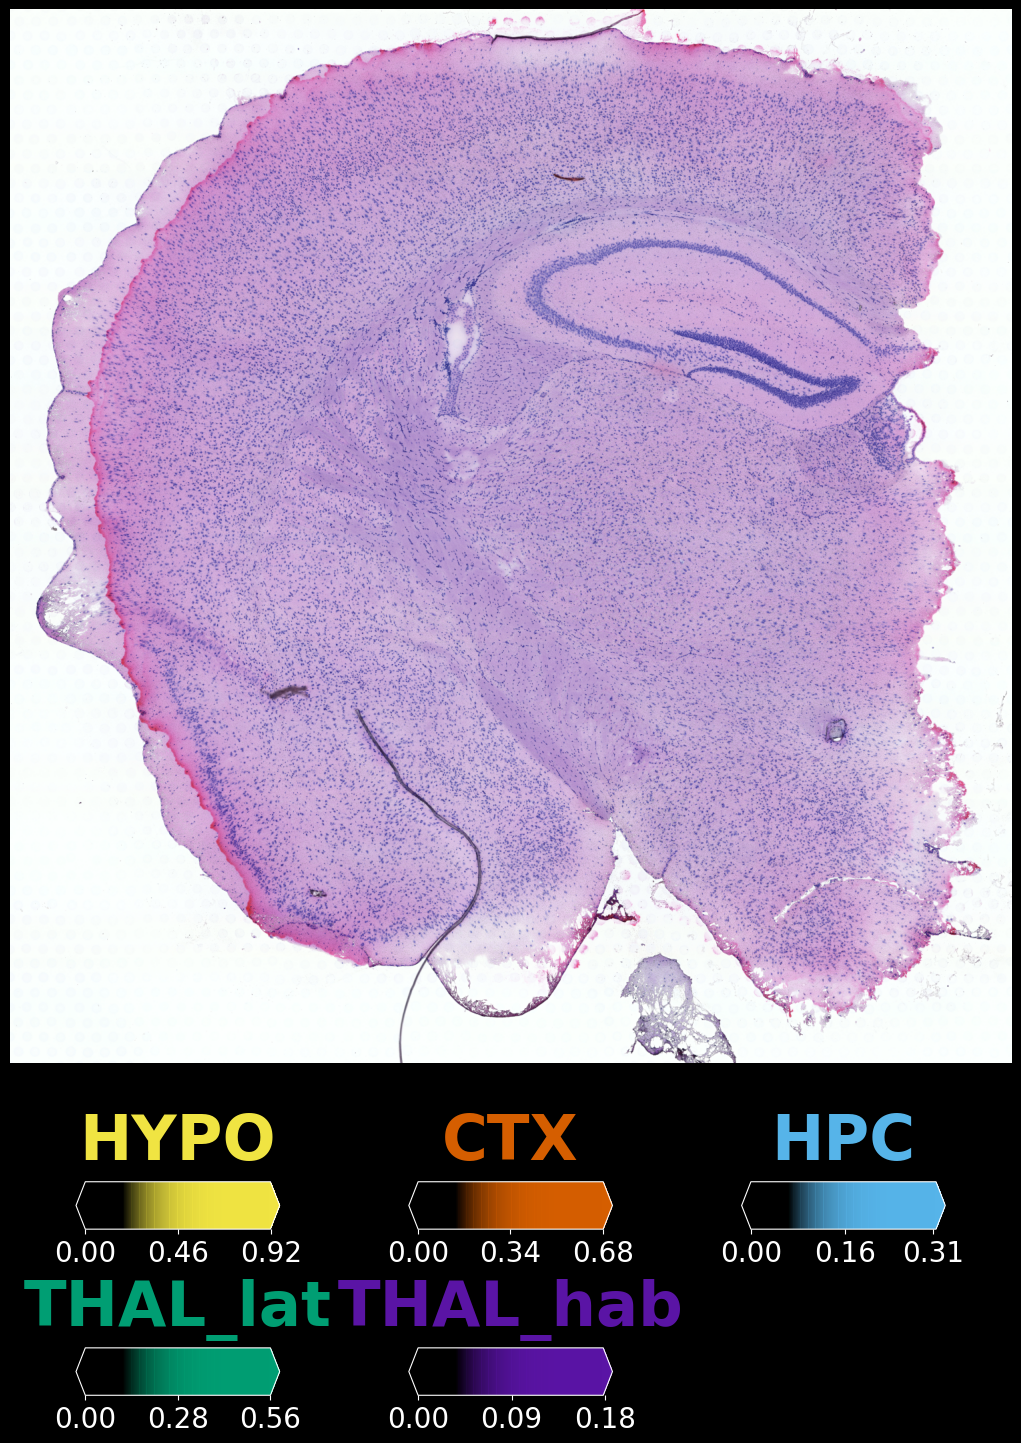

In [10]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 6 clusters 
sel_clust = ['Astro_HYPO','Astro_CTX','Astro_HPC','Astro_THAL_lat', 'Astro_THAL_hab']
sel_clust_lab = ['HYPO','CTX','HPC','THAL_lat', 'THAL_hab']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')
crop_x, crop_y = get_crop_coord(slide)

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (15,18)}):

    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=1,
                  #max_col=np.array((1, 1, 1, 1, 1, 1, 1)) * 0.7,
                  max_color_quantile=0.98, #reorder_cmap=[0,4],
              img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=10, alpha_scaling=0, labels=sel_clust_lab, 
                 style='dark_background', # fast dark_background
              crop_x=crop_x, crop_y=crop_y,
                 colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                 colorbar_shape={'vertical_gaps': 0.31, 'horizontal_gaps': 1, 
                                 'width': 3.5, 'height': 0.045},
                 colorbar_tick_size=20)
    fig.savefig(f'{fig_path}Fig2C_multicell_maps.pdf',
                bbox_inches='tight', facecolor='black')

### Fig S6C <a class="anchor" id="FigS6C"></a> 

In [11]:
def plot_hist2d(x, y, x_lab, y_lab, title_prefix='',
                x_min=0, y_min=0, axis_equal=True):
    plt.hist2d(x, y, bins=50, cmap='magma',
               norm=matplotlib.colors.LogNorm(),
              );
    #plt.scatter(x, y);
    plt.xlabel(x_lab);
    plt.ylabel(y_lab);
    plt.xlim(x_min)
    plt.ylim(y_min)
    if axis_equal:
        plt.gca().set_aspect('equal', adjustable='box')
    
    from scipy.stats import spearmanr
    cor = np.corrcoef(x, y)[0, 1]
    cor, pval = spearmanr(x, y)
    plt.title(title_prefix + r' $R^2$: ' + str(np.round(cor,3)))

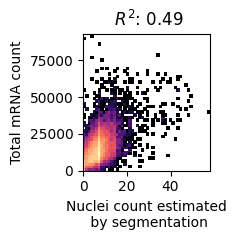

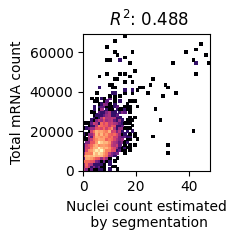

In [18]:
rcParams["figure.figsize"] = [2.3, 2.5]
x = adata_vis.obs['nuclei_count'].values.flatten()
y = adata_vis.obs['total_counts'].values.flatten()
plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
            y_lab=r'Total mRNA count', 
            title_prefix='', axis_equal=False)
plt.tight_layout()
plt.savefig('figures/FigS6/FigS6C_nuclei_total_UMI_count.pdf',
                    bbox_inches='tight', facecolor='white')
plt.show()

rcParams["figure.figsize"] = [2.3, 2.5]
s = 'ST8059048'
s_ind = adata_vis.obs['sample'] == s
x = adata_vis.obs.loc[s_ind,'nuclei_count'].values.flatten()
y = adata_vis.obs.loc[s_ind,'total_counts'].values.flatten()
plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
            y_lab=r'Total mRNA count', 
            title_prefix='', axis_equal=False)
plt.tight_layout()
plt.savefig(f'figures/FigS6/FigS6C_nuclei_total_UMI_count_one_sample{s}.pdf',
                    bbox_inches='tight', facecolor='white')
plt.show()

### Fig S6D <a class="anchor" id="FigS6D"></a> 

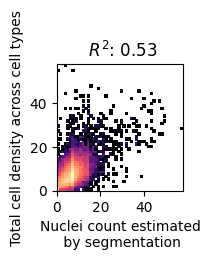

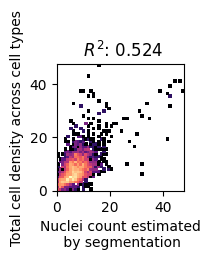

In [20]:
rcParams["figure.figsize"] = [2.5, 2.4]
x = adata_vis.obs['nuclei_count'].values.flatten()
y = adata_vis.uns['mod']['post_sample_means']['spot_factors'].sum(1).flatten()
plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
            y_lab=r'Total cell density across cell types', 
            title_prefix='')
plt.tight_layout()
plt.savefig('figures/FigS6/FigS6D_nuclei_total_cell_density.pdf',
                    bbox_inches='tight', facecolor='white')
plt.show()

rcParams["figure.figsize"] = [2.5, 2.4]
x = adata_vis.obs.loc[s_ind,'nuclei_count'].values.flatten()
y = adata_vis.uns['mod']['post_sample_means']['spot_factors'].sum(1).flatten()[s_ind]
plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
            y_lab=r'Total cell density across cell types', 
            title_prefix='')
plt.tight_layout()
plt.savefig(f'figures/FigS6/FigS6D_nuclei_total_cell_density_one_sample{s}.pdf',
                    bbox_inches='tight', facecolor='white')
plt.show()